In [353]:
%pylab inline

In [370]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

Peut-on établir un lien entre la densité de médecins par spécialité  et par territoire et la pratique
du dépassement d'honoraires ?<br>
Est-ce  dans les territoires où la densité est la plus forte que les médecins  pratiquent le moins les
dépassement d'honoraires ?<br>
Est ce que la densité de certains médecins / praticiens est corrélée à la densité de population pour
certaines classes d'âges (bebe/pediatre, personnes agées / infirmiers etc...) ?

In [355]:
"""
On choisira comme granularité de territoire le département (plus significatif que la région)

1/ Pour les dépassements d'honoraires sur les praticiens spécialistes :
On dispose d'un jeu de données disponibles sur 2013 : sur le site ameli.fr
ici : http://www.ameli.fr/fileadmin/user_upload/documents/Honoraires_totaux_des_professionnels_de_sante_par_departement_en_2013.xls
2/ Les données du point 1 étant relatives à 2013, on les mettra en regard des données de densité de 2013 qu'on récupérera
sous format csv à partir de http://www.data.drees.sante.gouv.fr/ReportFolders/reportFolders.aspx?IF_ActivePath=P,490,497,514

Pour les questions de mise en regard de la densité de spécialistes avec la structure de la population par tranche
d'âge, on utilisera les données de l'insee et en particulier le fichier suivant :
http://www.insee.fr/fr/ppp/bases-de-donnees/donnees-detaillees/estim-pop/estim-pop-dep-sexe-aq-1975-2014.xls
"""

import requests
from bs4 import BeautifulSoup
#import re
import json
import pandas as pd
import sys
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
import statsmodels.formula.api as smf
from IPython.html import widgets

reload(sys)
sys.setdefaultencoding("utf-8")
sns.set(color_codes=True)


In [356]:
global simple_columns
simple_columns = [
    'DEPARTEMENT',
    'TTES_SPECIALITES',
    'SPECIALISTES',
    'ANATOMIE',
    'ANESTHESIE',
    'BIOLOGIE',
    'CARDIOLOGIE',
    'CHIRURGIE',
    'STOMATOLOGIE',
    'TRAUMATOLOGIE',
    'CHIR_INFANT',
    'CHIR_PLASTIQUE',
    'CHIR_CARDIO',
    'CHIR_UROLOGIQUE',
    'CHIR_VASCULAIRE',
    'CHIR_DISGESTIVE',
    'DERMATOLOGIE',
    'ENDOCRINOLOGIE',
    'GENETIQUE',
    'GERIATRIE',
    'GYNECOLOGIE',
    'OBSTETRIQUE',
    'HEMATOLOGIE',
    'HEPATOLOGIE',
    'MEDECINE_TRAVAIL',
    'MEDECINE_INTERNE',
    'MEDECINE_NUCLEAIRE',
    'READAPTATION',
    'NEPHROLOGIE',
    'NEURO_CHIRURGIE',
    'NEUROLOGIE',
    'ORL',
    'ONCOLOGIE',
    'OPHTALMOLOGIE',
    'PEDIATRIE',
    'PNEUMOLOGIE',
    'PSYCHIATRIE',
    'RADIOLOGIE',
    'RADIO_THERAPIE',
    'REANIMATION',
    'RECHERCHE',
    'RHUMATOLOGIE',
    'MEDECINE_SOCIALE',
    'GENERALISTES',
    'MEDECINE_GENERALE'
]

global ameli_spe_codes
ameli_spe_codes = {
    '37': 'ANATOMIE',
    '02': 'ANESTHESIE',
    '38': 'BIOLOGIE',
    '03': 'CARDIOLOGIE',
    '04': 'CHIRURGIE',
    '18': 'STOMATOLOGIE',
    '44': 'STOMATOLOGIE',
    '45': 'STOMATOLOGIE',
    '41': 'TRAUMATOLOGIE',
    '43': 'CHIR_INFANT',
    '46': 'CHIR_PLASTIQUE',
    '47': 'CHIR_CARDIO',
    '16': 'CHIR_UROLOGIQUE',
    '48': 'CHIR_VASCULAIRE',
    '49': 'CHIR_DISGESTIVE',
    '05': 'DERMATOLOGIE',
    '42': 'ENDOCRINOLOGIE',
    '78': 'GENETIQUE',
    '34': 'GERIATRIE',
    '70': 'GYNECOLOGIE',
    '07': 'OBSTETRIQUE',
    '77': 'OBSTETRIQUE',
    '79': 'OBSTETRIQUE',
    '71': 'HEMATOLOGIE',
    '08': 'HEPATOLOGIE',
    '09': 'MEDECINE_INTERNE',
    '72': 'MEDECINE_NUCLEAIRE',
    '31': 'READAPTATION',
    '35': 'NEPHROLOGIE',
    '10': 'NEURO_CHIRURGIE',
    '32': 'NEUROLOGIE',
    '11': 'ORL',
    '73': 'ONCOLOGIE',
    '15': 'OPHTALMOLOGIE',
    '12': 'PEDIATRIE',
    '13': 'PNEUMOLOGIE',
    '33': 'PSYCHIATRIE',
    '75': 'PSYCHIATRIE',
    '17': 'PSYCHIATRIE',
    '06': 'RADIOLOGIE',
    '74': 'RADIO_THERAPIE',
    '76': 'RADIO_THERAPIE',
    '20': 'REANIMATION',
    '14': 'RHUMATOLOGIE'
}

global pop_columns
pop_columns = [
    'DEP_ID', 'DEPARTEMENT',
    '0_4', '5_9', '10_14', '15_19', '20_24', '25_29', '30_34', '35_39', '40_44', '45_49', '50_54', '55_59', '60_64',
    '65_69', '70_74', '75_79', '80_84', '85_89', '90_95', '95_et_plus'
]


In [357]:
#
# Replace several substrings in string
#
def replace_non_ascii(text):
    dic = {'é': 'e', 'è': 'e', 'ô': 'o'}
    if not text is None:
        for i, j in dic.iteritems():
            text = text.replace(i, j)
    return text

def replace_bad_dpt(dep):
    if not dep is None:
        dep = dep.upper()
        if dep == "SEINE-ST-DENIS":
            dep = "SEINE-SAINT-DENIS"
        elif dep == "ALPES-HTE-PROVENCE":
            dep = "ALPES-DE-HAUTE-PROVENCE"
        elif dep == "TERR":
            dep = "TERRITOIRE DE BELFORT"
    return dep

#
# Chargement dataset des densités de spécialistes
#
def getDensites():
    global simple_columns
    df_densites = pd.read_csv("rpps-medecin-densite-2013.csv", header=34, encoding="iso-8859-1")
    df_densites.columns = simple_columns
    df_densites['DEPARTEMENT'] = df_densites['DEPARTEMENT'].map(replace_non_ascii)
    df_densites['DEPARTEMENT'] = df_densites['DEPARTEMENT'].str.extract("-\ ([A-Z][A-Za-z\ \-']*)")
    df_densites['DEPARTEMENT'] = df_densites['DEPARTEMENT'].str.upper()
    print(len(df_densites))
    df_densites.index = df_densites['DEPARTEMENT'].loc[0:]
    print(len(df_densites))
    df_densites.drop('DEPARTEMENT', axis=1, inplace=True)
    print(len(df_densites))
    # Eliminer les colonnes inutiles
    df_densites.drop('MEDECINE_GENERALE', axis=1, inplace=True)
    df_densites.drop('GENERALISTES', axis=1, inplace=True)
    df_densites.drop('MEDECINE_SOCIALE', axis=1, inplace=True)
    df_densites.drop('MEDECINE_TRAVAIL', axis=1, inplace=True)
    df_densites.drop('MEDECINE_INTERNE', axis=1, inplace=True)
    df_densites.drop('TTES_SPECIALITES', axis=1, inplace=True)
    df_densites.drop('RECHERCHE', axis=1, inplace=True)
    return df_densites

def getDepassementsSpe():
    global ameli_spe_codes
    df = pd.read_excel("Honoraires_prof_sante_par_dep_2013.xls", sheetname='Spécialistes',
                       encoding='UTF-8', na_values=['nc'], thousands=' ', keep_default_na=False,
                       skip_footer=4017)
    # remove columns from 2 to 7
    df = df.drop(df.columns[range(2, 8)], axis=1)
    # set columns titles
    df.columns = ['SPECIALITE', 'DEPARTEMENT', 'DEPASSEMENT']
    # select and remove rows with first column begining with TOTAL
    select = df.iloc[:, 0].str.startswith('TOTAL')
    df = df.drop(df[select].index)
    # select and remove rows with second column begin ing with TOTAL
    select = df.iloc[:, 1].str.startswith('TOTAL')
    df = df.drop(df[select].index)
    df = df.reset_index(drop=True)
    df.iloc[:, 1] = df.iloc[:, 1].map(replace_non_ascii)
    df.iloc[:, 1] = df.iloc[:, 1].str.extract("-\ ([A-Z][A-Za-z\ \-']*)")
    df.iloc[:, 1] = df.iloc[:, 1].str.upper()
    df.iloc[:, 1] = df.iloc[:, 1].map(replace_bad_dpt)
    # keep only code for SPECIALITE
    df['SPECIALITE'] = df['SPECIALITE'].str[0:2]
    df['SPECIALITE'] = df['SPECIALITE'].map(ameli_spe_codes)
    #df.to_csv('dep1.csv')
    grp = df.groupby(['DEPARTEMENT', 'SPECIALITE'])
    depassement_sums = grp['DEPASSEMENT'].sum()
    depassement_sums = depassement_sums.copy()
    df.drop('DEPASSEMENT', axis=1, inplace=True)
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    depassement_sums = depassement_sums.reset_index(drop=True)
    df['DEPASSEMENT'] = depassement_sums
    #df.to_csv('dep2.csv')
    df.index = df['DEPARTEMENT']
    df.drop('DEPARTEMENT', axis=1, inplace=True)
    df = df.drop(['DEPARTEMENT'])
    return df

#
# Chargement du dataset de données insee sur la structure des populations par département
#
def getPopulationDF():
    global pop_columns
    df = pd.read_excel("estim-pop-dep.xls", sheetname="2013", parse_cols=21, skiprows=4, skip_footer=4)
    df.columns = pop_columns
    df = df.drop([96])
    #df = df.dropna()
    df['DEPARTEMENT'] = df['DEPARTEMENT'].map(replace_non_ascii)
    df['DEPARTEMENT'] = df['DEPARTEMENT'].str.upper()
    df.index = df['DEPARTEMENT']
    df.drop('DEP_ID', axis=1, inplace=True)
    df.drop('DEPARTEMENT', axis=1, inplace=True)
    return df


In [358]:
df_densites = getDensites()
# on élimine MAYOTTE pour laquelle on n'a pas de données de recensement insee
df_densites = df_densites.drop(['MAYOTTE'])
#df_densites.head()

In [359]:
df_depassements = getDepassementsSpe()
# on élimine MAYOTTE pour laquelle on n'a pas de données de recensement insee
df_depassements = df_depassements.drop(['MAYOTTE'])
#df_depassements.head()

In [360]:
df_pop = getPopulationDF()
#df_pop.head()

In [361]:
# Get departement list in json
departements = pd.Series(df_pop.index.copy())
json_dpts = departements.to_json(orient='records')

# Création de la liste des spécialités en json
global simple_columns
simple_columns
specialites = pd.Series(simple_columns)
specialites.drop([0,1,2], inplace=True)
json_spe = specialites.to_json(orient='records')

# Classes d'âge en json
ages = pd.Series(pop_columns[2:])
json_ages = ages.to_json(orient='records')


In [371]:
from IPython.display import HTML, Javascript, clear_output

spe_list = json.loads(json_spe)
clear_output(wait=True)
content = '<center><br><br><div style="background-color:gainsboro; border:solid black; width:600px; padding:20px;">'
content += 'Sélectionnez la spécialité: <select id="var_spe" value="foo">'
for spe in spe_list:
    content += '<option value="'+str(spe)+'">'+str(spe)+'</option>'
content += '</select><br><br>'
content += '<button onclick="apply_test_corre1()">Tester corrélation densité spécialistes / dépassements honoraires</button>'
content += '</div></center>'
display(HTML(content))


javascript = """
<script type="text/Javascript">
    function apply_test_corre1(){
        var var_value = document.getElementById('var_spe').value;
        var kernel = IPython.notebook.kernel;
        // Create a python variable named var_spe
        kernel.execute("var_spe = '"+var_value+"'");
        // execute cells below
        IPython.notebook.execute_cells_below()
        /*
        var var_value = document.getElementById('var_value').value;
        var command = var_name + " = '" + var_value + "'";
        console.log("Executing Command: " + command);
        
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
        IPython.notebook.execute_all_cells()
        */
    }
</script>
"""

HTML(javascript)

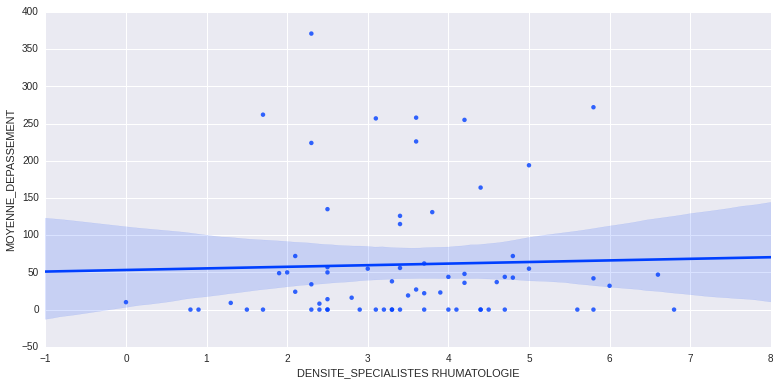

In [363]:
#var_spe
# filtrer les dépassements pas la spécialité sélectionnée
df_depassements_rl = df_depassements[df_depassements['SPECIALITE']==var_spe]
# faire une jointure avec le dataframe des densites
df = df_densites.join(df_depassements_rl)
df = df[[var_spe,'DEPASSEMENT']]
df = df.dropna()
X = df[[var_spe]]
y = df['DEPASSEMENT']
# centrer/réduire X
mean = X.mean()
std = X.std()
Xcr = (X - mean)/std
#dat = pd.concat([Xcr, y-y.mean()], axis=1)
dat = pd.concat([X, y], axis=1)
title = 'DENSITE_SPECIALISTES '+var_spe
dat.columns = [title, 'MOYENNE_DEPASSEMENT']
#print(dat)
#plt.scatter(Xcr, y, c='blue', alpha=0.5)
sns.set_palette("bright")
fig1, ax = plt.subplots(figsize=(13, 6))
ax = sns.regplot(x=title, y='MOYENNE_DEPASSEMENT', data=dat, ci=95)

## Identification des outliers

On considère outliers les départements pour lesquels des dépassements excèdent 4 fois la médiane des dépassements

In [364]:
# Médiane des dépassements
med = df['DEPASSEMENT'].median()
df_outliers = df[df['DEPASSEMENT'] > 4*med]
df_outliers.sort(columns=['DEPASSEMENT'], ascending=False)

,RHUMATOLOGIE,DEPASSEMENT
DEPARTEMENT,,
MAYENNE,2.3,371
HAUTE-VIENNE,5.8,272
HAUTE-SAONE,1.7,262
MORBIHAN,3.6,258
CALVADOS,3.1,257
VAR,4.2,255
MANCHE,3.6,226
NIEVRE,2.3,224
MEURTHE-ET-MOSELLE,5.0,194


## Corrélation potentielle entre la densité de certains spécialistes et l'effectif de certaines classes d'âge
On travaille sur tout le territoire et dans un 1er temps, on conserve les quantiles d'âges tels que définis dans le fichier insee<br>

In [365]:
spe_list = json.loads(json_spe)
ages_list = json.loads(json_ages)
clear_output(wait=True)
content = '<center><br><br><div style="background-color:gainsboro; border:solid black; width:600px; padding:20px;">'
content += 'Sélectionnez la spécialité: <select id="var_spe2">'
for spe in spe_list:
    content += '<option value="'+str(spe)+'">'+str(spe)+'</option>'
content += '</select><br><br>'
content += 'Sélectionnez la classe d&apos;&acirc;ge: <select id="var_age">'
for age in ages_list:
    content += '<option value="'+str(age)+'">'+str(age)+'</option>'
content += '</select><br><br>'
content += '<button onclick="apply_test_corre2()">Tester corrélation densité spécialistes / classe d&apos;&acirc;ge</button>'
content += '</div></center>'
display(HTML(content))


javascript = """
<script type="text/Javascript">
    function apply_test_corre2(){
        var var_value = document.getElementById('var_spe2').value;
        var var_vage = document.getElementById('var_age').value;
        var kernel = IPython.notebook.kernel;
        // Create a python variable named var_spe
        kernel.execute("var_spe2 = '"+var_value+"'");
        kernel.execute("var_age = '"+var_vage+"'");
        // execute cells below
        IPython.notebook.execute_cells_below()
        /*
        var var_value = document.getElementById('var_value').value;
        var command = var_name + " = '" + var_value + "'";
        console.log("Executing Command: " + command);
        
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
        IPython.notebook.execute_all_cells()
        */
    }
</script>
"""

HTML(javascript)

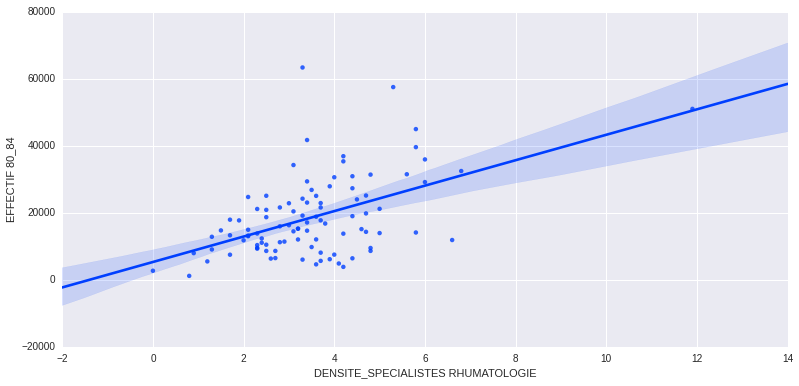

In [366]:
#var_spe2 et var_age
# faire une jointure dataframe des densites / dataframe population
df2 = df_densites.join(df_pop)
df2 = df2[[var_spe2,var_age]]
df2 = df2.dropna()
X2 = df2[[var_spe2]]
y2 = df2[var_age]
# centrer/réduire X
mean2 = X2.mean()
std2 = X2.std()
Xcr2 = (X2 - mean2)/std2
#dat = pd.concat([Xcr, y-y.mean()], axis=1)
dat2 = pd.concat([X2, y2], axis=1)
title2 = 'DENSITE_SPECIALISTES '+var_spe2
title22 = 'EFFECTIF '+var_age
dat2.columns = [title2, title22]
#print(dat)
#plt.scatter(Xcr, y, c='blue', alpha=0.5)
sns.set_palette("bright")
fig1, ax = plt.subplots(figsize=(13, 6))
ax = sns.regplot(x=title2, y=title22, data=dat2, ci=95)

On propose un autre axe d'étude du sujet en définissant une structuration des populations en 5 grandes classes d'âge :<br>
<ul>
<li>enfant (de 0 à 14 ans)</li>
<li>jeune (de 15 à 29 ans)</li>
<li>âge médian (de 30 à 49 ans)</li>
<li>sénior (de 50 à 69 ans)</li>
<li>personne âgée (70 ans et plus)</li>
</ul>

In [367]:
# Restructuration du dataset insee

def replace_classe_age(text):
    if not text is None:
        if text == '0_4' or text == '5_9' or text == '10_14':
            text = '0_14'
        elif text == '15_19' or text == '20_24' or text == '25_29':
            text = '15_29'
        elif text == '30_34' or text == '35_39' or text == '40_44' or text == '45_49':
            text = '30_49'
        elif text == '50_54' or text == '55_59' or text == '60_64' or text == '65_69':
            text = '50_69'
        else:
            text = '70_et_plus'
    return text

df_pop2 = df_pop.transpose()
df_pop2.reset_index(inplace=True)
df_pop2.rename(columns={'index': 'CLASSE_AGE'}, inplace=True)
df_pop2['CLASSE_AGE'] = df_pop2['CLASSE_AGE'].map(replace_classe_age)
df_grp_pop2 = df_pop2.groupby(['CLASSE_AGE']).sum().transpose()
#df_grp_pop2.columns = df_grp_pop2.iloc[0,:]
#df_grp_pop2

In [376]:
# 2èmes Classes d'âge en json
ages2 = pd.Series(df_grp_pop2.columns)
json_ages2 = ages2.to_json(orient='records')

spe_list = json.loads(json_spe)
ages2_list = json.loads(json_ages2)
clear_output(wait=True)
content = '<center><div style="background-color:gainsboro; border:solid black; width:600px; padding:20px;">'
content += 'Sélectionnez la spécialité: <select id="var_spe3">'
for spe in spe_list:
    content += '<option value="'+str(spe)+'">'+str(spe)+'</option>'
content += '</select><br><br>'
content += 'Sélectionnez la classe d&apos;&acirc;ge: <select id="var_age2">'
for age in ages2_list:
    content += '<option value="'+str(age)+'">'+str(age)+'</option>'
content += '</select><br><br>'
content += '<button onclick="apply_test_corre3()">Tester corrélation densité spécialistes / classe d&apos;&acirc;ge</button>'
content += '</div></center>'
display(HTML(content))


javascript = """
<script type="text/Javascript">
    function apply_test_corre3(){
        var var_value = document.getElementById('var_spe3').value;
        var var_vage = document.getElementById('var_age2').value;
        var kernel = IPython.notebook.kernel;
        // Create a python variable named var_spe
        kernel.execute("var_spe3 = '"+var_value+"'");
        kernel.execute("var_age2 = '"+var_vage+"'");
        // execute cells below
        IPython.notebook.execute_cells_below()
        /*
        var var_value = document.getElementById('var_value').value;
        var command = var_name + " = '" + var_value + "'";
        console.log("Executing Command: " + command);
        
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
        IPython.notebook.execute_all_cells()
        */
    }
</script>
"""

HTML(javascript)

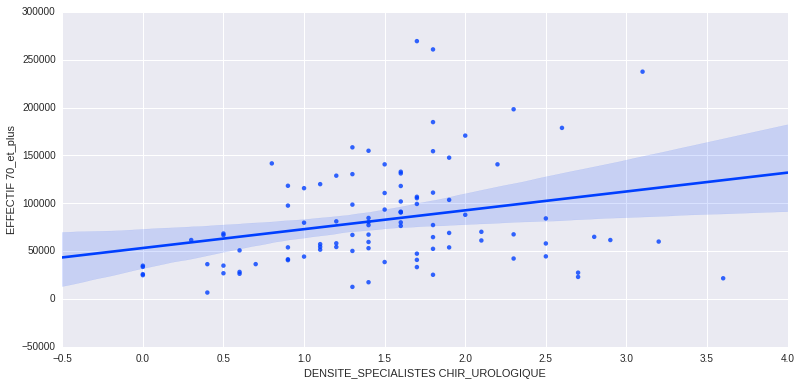

In [377]:
#var_spe3 et var_age2
# faire une jointure dataframe des densites / dataframe population
df3 = df_densites.join(df_grp_pop2)
df3 = df3[[var_spe3,var_age2]]
df3 = df3.dropna()
X3 = df3[[var_spe3]]
y3 = df3[var_age2]
# centrer/réduire X
mean3 = X3.mean()
std3 = X3.std()
Xcr3 = (X3 - mean3)/std3
#dat = pd.concat([Xcr, y-y.mean()], axis=1)
dat3 = pd.concat([X3, y3], axis=1)
title3 = 'DENSITE_SPECIALISTES '+var_spe3
title33 = 'EFFECTIF '+var_age2
dat3.columns = [title3, title33]
#print(dat)
#plt.scatter(Xcr, y, c='blue', alpha=0.5)
sns.set_palette("bright")
fig1, ax = plt.subplots(figsize=(13, 6))
ax = sns.regplot(x=title3, y=title33, data=dat3, ci=95)